In [1]:
from scipy.integrate import odeint, solve_ivp
import numpy as np
from numpy.random import default_rng
import plotly.graph_objects as go
import plotly.io as pio
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.figure_factory as ff
import plotly.offline as py
import sys

In [280]:
### initialize given values
covariance_v_t0 = 200**2  # (ft/sec)^2
Vc = 300.0 # ft/sec
covariance_at = 100**2    # (ft/sec^2)^2
tf = 10.0 # sec
R1 = 15.0e-6 # rad^2/sec
R2 = 1.67e-3 # rad^2/sec^3
tau = 2.0 # sec
npts = 1001
timevec = np.linspace(0, tf, npts)
dt = timevec[1] - timevec[0]

### initialize provided matrices in the dynamic equations
F = np.array([
    [0, 1, 0],
    [0, 0, -1],
    [0, 0, -1/tau]
])
G = np.array([0, 0, 1])
W = np.array([
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, covariance_at]
])
H_bar = np.array([[1, 0, 0]])
P0 = np.array([
    [0, 0, 0],
    [0, covariance_v_t0, 0],
    [0, 0, covariance_at]
]).reshape((9,))
xhat0 = np.array([0, 0, 0])
xhat0_and_P0 = np.concatenate((xhat0, P0))

# initialize the random noise generator
rng = default_rng()

In [299]:
print(timevec.shape)
# for i in range(timevec)

(1001,)


See numpy's [random number generator ref](https://numpy.org/doc/stable/reference/random/generator.html) for more. 
The noise is not Gaussian, but instead looks more like laplace.

It's actually an [Ornstein-Uhlenbeck Process](https://www.lanl.gov/DLDSTP/fast/OU_process.pdf) with zero mean and exponential correlation function. See Section 4 in the link on how to simulate this.

[Simulating a stochastic differential equation in Python](https://ipython-books.github.io/134-simulating-a-stochastic-differential-equation/)

See scipy's [odeint ref](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html) or [solve_ivp ref](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html#scipy.integrate.solve_ivp) for more on how to use the functions.

In [281]:
def statespace(t, x, w):
    w_i = np.searchsorted(timevec, t, side='right') - 1
    return F.dot(x) + G.dot(w[w_i])

In [282]:
def kalmanFilter(t, xhat_and_P, z):
    # this function propagates the dynamics of the Kalman Filter
    # inputs:
    # - t: a float representing the current time
    # - xhat_and_P: a numpy array with shape (3, 4) where the elements in the first column (:,0) 
    #               represent the state estimation and the elements in the remaining three columns 
    #               represent the covariance associated with the state estimate
    xhat = xhat_and_P[0:3]
    P = xhat_and_P[3:].reshape((3,3))
    z_i = np.searchsorted(timevec, t, side='right') - 1

    # Kalman gains
    K1 = P[0,0] / (Vc * R1 * (tf - t) + Vc * R2 / (tf - t))
    K2 = P[0,1] / (Vc * R1 * (tf - t) + Vc * R2 / (tf - t))
    K3 = P[0,2] / (Vc * R1 * (tf - t) + Vc * R2 / (tf - t))
    
    # belief state in theta (the LOS angle)
    thetahat = xhat[0] / (Vc*(tf - timevec[z_i]))
    
    # residual
    residual = z[z_i] - thetahat # yhatdot = vhat + K_n (z - thetahat)
    
    # CT equations for the belief state
    xhatdot = np.zeros(3)
    xhatdot[0] = xhat[1] + K1 * residual
    xhatdot[1] = -xhat[2] + K2 * residual
    xhatdot[2] = -xhat[2]/tau + K3 * residual
    
    # CT equations for the covariance matrix
#     Pdot = F.dot(P) + P.dot(F.T) - 1 / (Vc**2 * R1 * (tf - t)**2 + Vc**2 * R2) * P.dot(H_bar.T).dot(H_bar).dot(P) + W
    Pdot = F.dot(P) + P.dot(F.T) - 1 / (Vc**2 * R1 * (tf - timevec[i])**2 + Vc**2 * R2) * P.dot(H_bar.T).dot(H_bar).dot(P) + W
    
    # format the output back into a 1-d array
    xhat_and_P_dot = np.concatenate((xhatdot, Pdot.reshape((9,))))
    
    return xhat_and_P_dot

In [295]:
def sim_run():
    # initialize the state for this run
    y0 = 0
    v0 = rng.normal(scale=np.sqrt(covariance_v_t0)) # std is 200 ft/sec
    aT0 = rng.normal(scale=np.sqrt(covariance_at))
    x0 = np.array([0, v0, aT0])

    noise_dt = 0.01
    # generate the noise
    w = rng.normal(scale=np.sqrt(covariance_at/noise_dt), size=npts) 
#     w = rng.normal(scale=np.sqrt(covariance_at), size=npts) 
    # simulate the true state
    sol = solve_ivp(statespace, [0, tf], x0, t_eval = timevec, args=(w,))
    # calculate the true LOS angle for this run
    theta = np.array([sol.y[0,i] / (Vc *(tf - timevec[i])) for i in range(npts-1)]) # up to n-1 to avoid divide by zero
    # generate the sensor measurement noise
    eta = np.array([rng.normal(scale=np.sqrt((R1 + R2/(tf - timevec[i])**2)/noise_dt)) for i in range(npts-1)]) # up to n-1 to match theta
#     eta = np.array([rng.normal(scale=np.sqrt((R1 + R2/(tf - timevec[i])**2))/dt) for i in range(npts-1)]) # up to n-1 to match theta
    # generate the sensor measurment by ading the noise to the true LOS angle
    z = theta + eta
    # run the CT Kalman Filter to produce state estimates and covariance over time
    filtersol = solve_ivp(kalmanFilter, [0, timevec[-2]], xhat0_and_P0, t_eval=timevec[0:-1], args=(z,))

    return sol, filtersol, theta, z

In [296]:
sol, filtersol, theta, z = sim_run()

# reconstruct K1, K2, and K3 from the covariance
K1 = [filtersol.y[3,i] / (Vc * R1 * (tf) + Vc * R2 / (tf - filtersol.t[i])) for i in range(filtersol.y.shape[1])]
K2 = [filtersol.y[4,i] / (Vc * R1 * (tf) + Vc * R2 / (tf - filtersol.t[i])) for i in range(filtersol.y.shape[1])]
K3 = [filtersol.y[5,i] / (Vc * R1 * (tf) + Vc * R2 / (tf - filtersol.t[i])) for i in range(filtersol.y.shape[1])]

# reconstruct the standard deviation of each state error from the covariance
std_pos = [np.sqrt(filtersol.y[3,i]) for i in range(filtersol.y.shape[1])]
std_vel = [np.sqrt(filtersol.y[7,i]) for i in range(filtersol.y.shape[1])]
std_accel = [np.sqrt(filtersol.y[11,i]) for i in range(filtersol.y.shape[1])]

# reconstruct the residual
residual = np.array([z[i] - filtersol.y[0,i] / (Vc*(tf - timevec[i])) for i in range(filtersol.y.shape[1])])

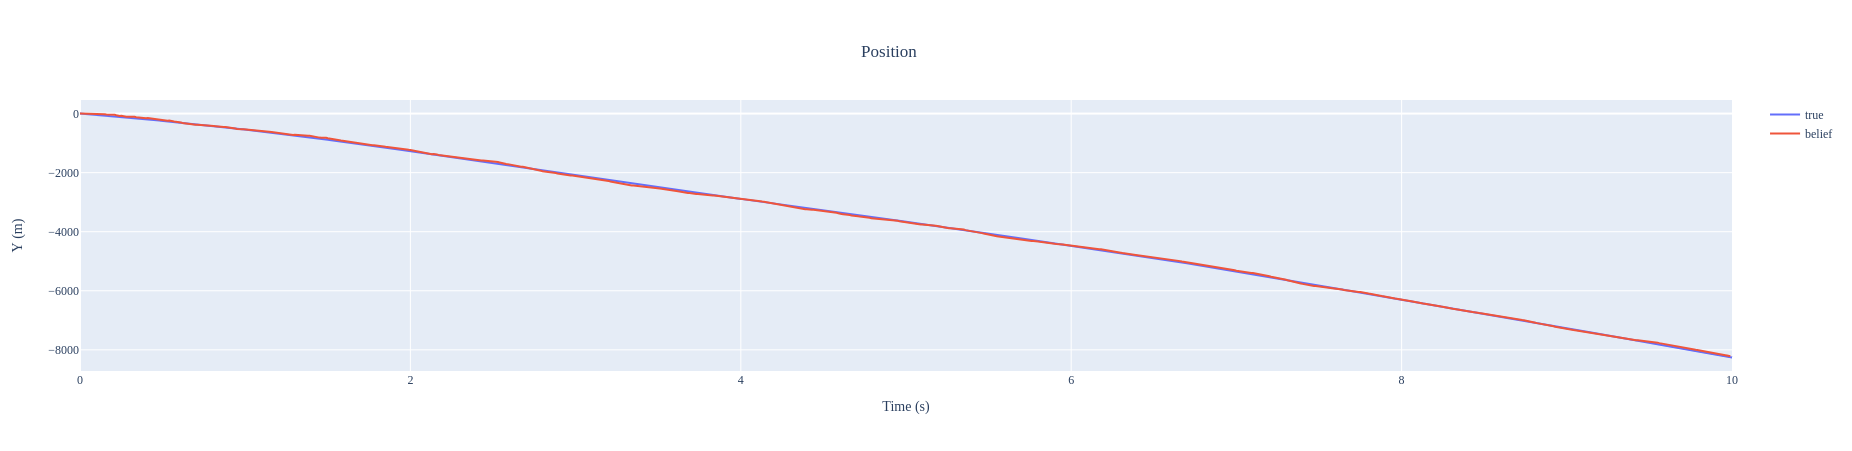

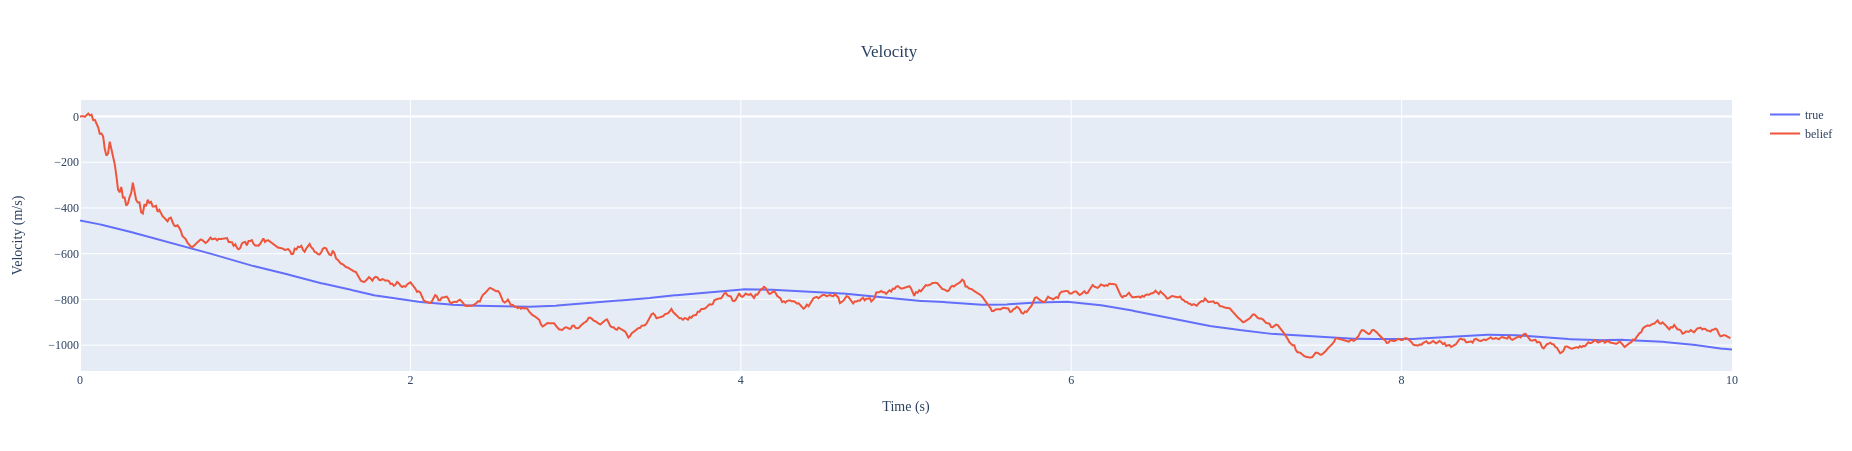

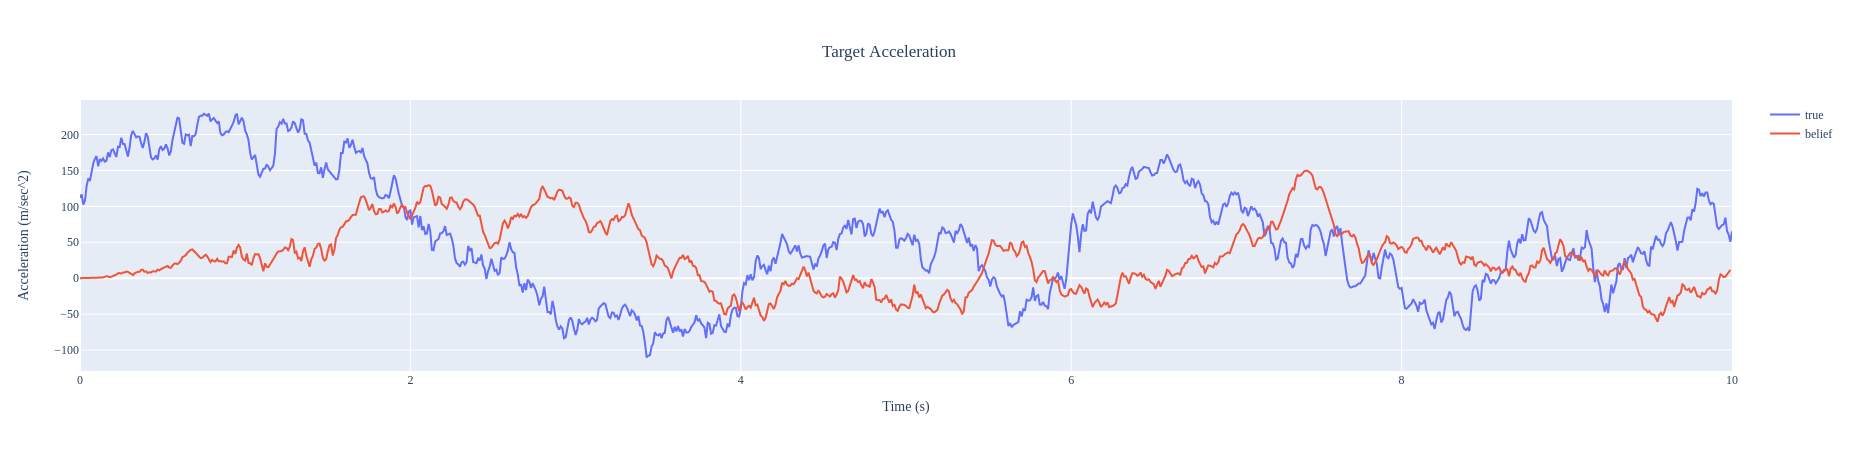

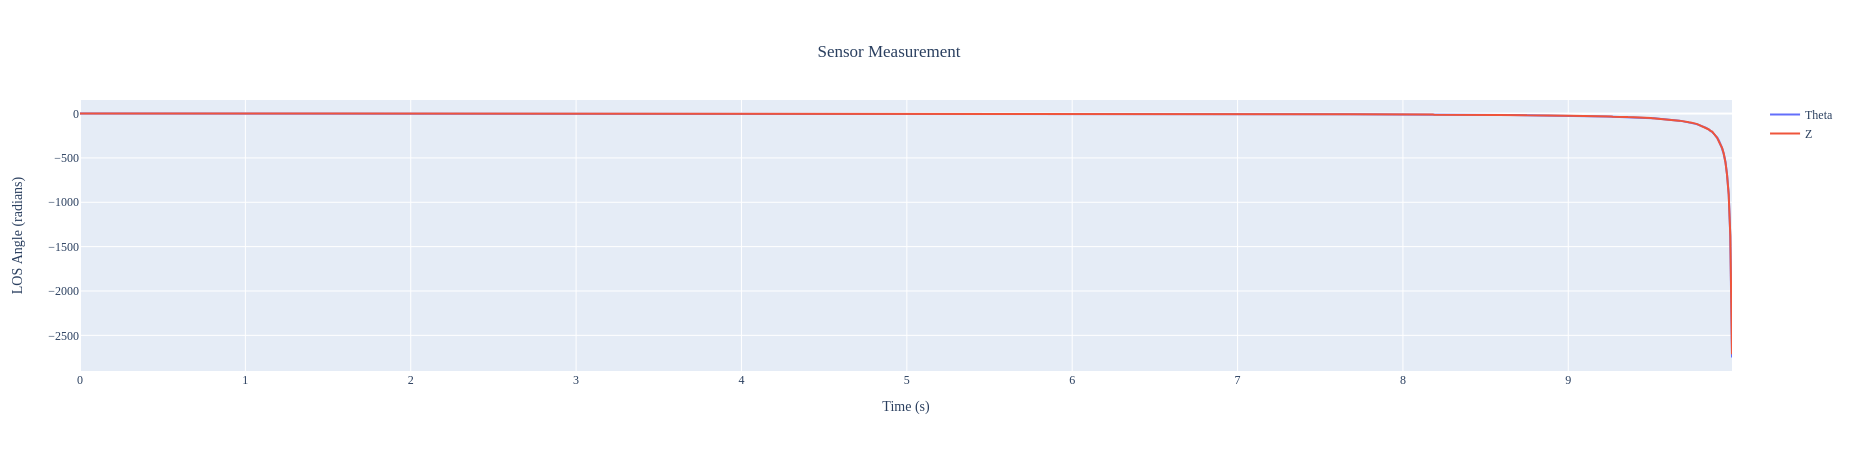

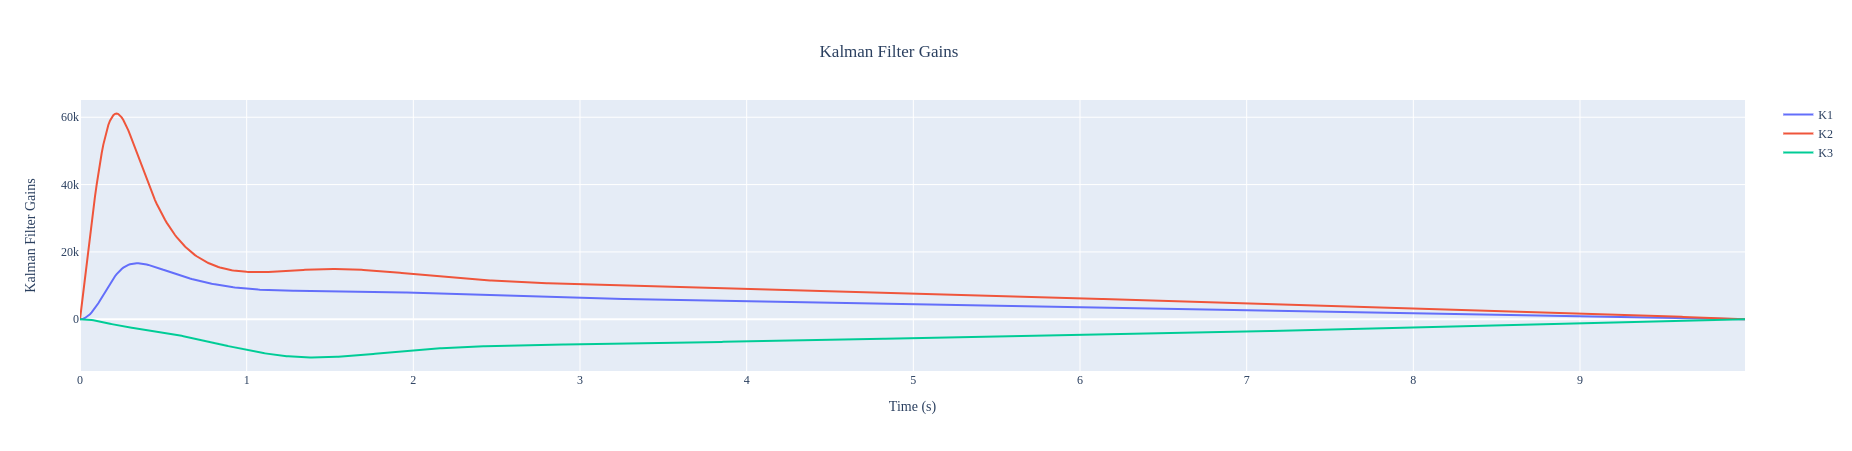

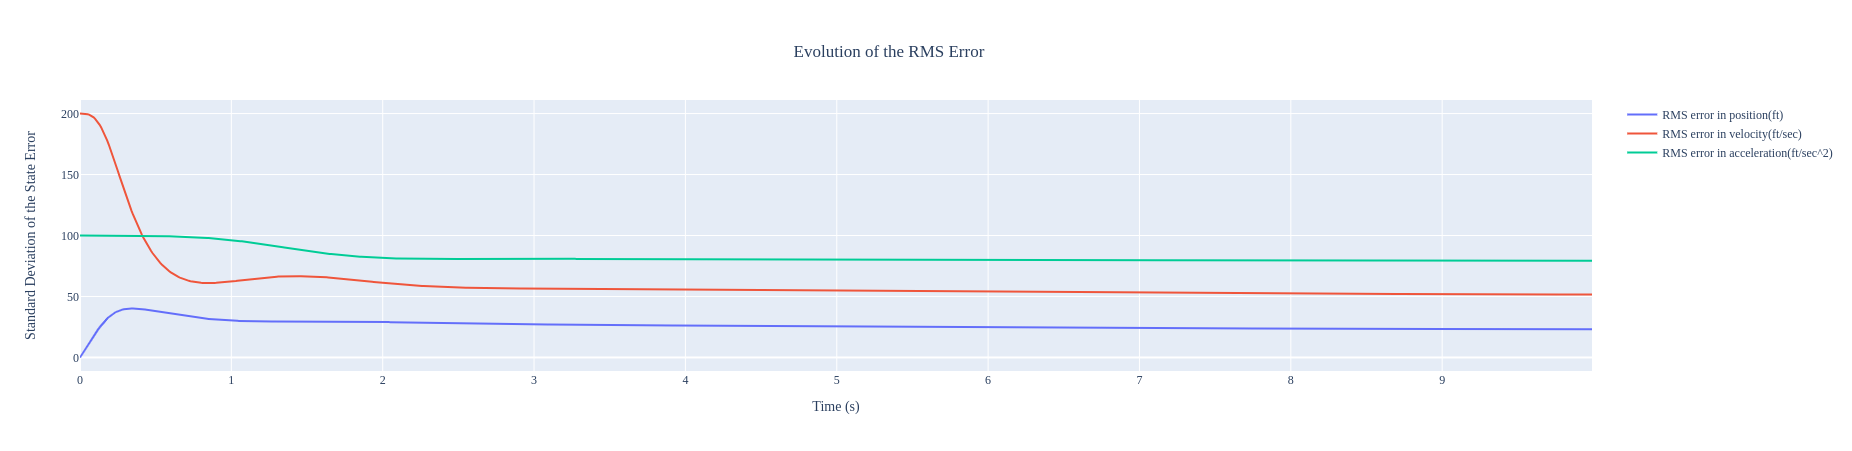

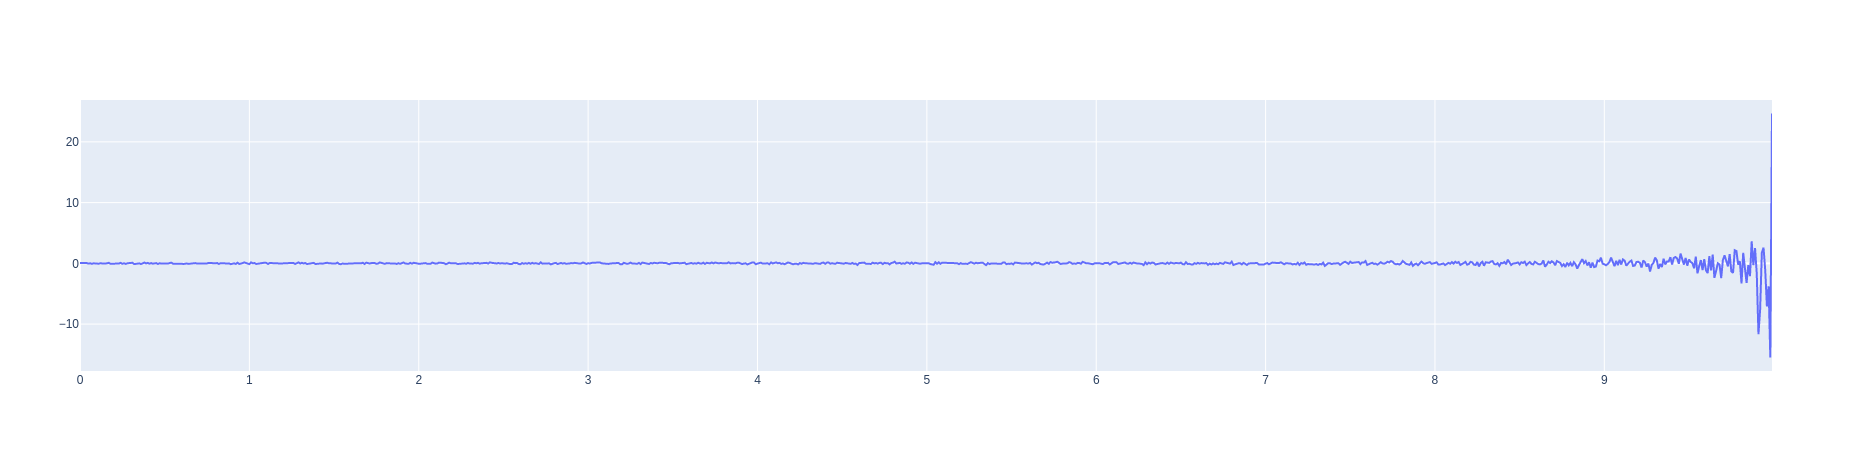

In [297]:
# Position
figy = go.Figure()
figy.add_trace(go.Scatter(x=timevec, y=sol.y[0,:], name="true"))
figy.add_trace(go.Scatter(x=timevec[0:-1], y=filtersol.y[0,:], name="belief"))
figy.update_layout(font = dict(family=myfont), title={'text':"Position",'xanchor':'center','yanchor':'top','y':0.9,'x':0.48}, xaxis = { 'title' : {'text' : "Time (s)", 'font' : { 'family' : myfont } } } , yaxis_title="Y (m)")
figy.show()

# Velocity
figv = go.Figure()
figv.add_trace(go.Scatter(x=timevec, y=sol.y[1,:], name='true'))
figv.add_trace(go.Scatter(x=timevec[0:-1], y=filtersol.y[1,:], name='belief'))
figv.update_layout(font = dict(family=myfont), title={'text':"Velocity",'xanchor':'center','yanchor':'top','y':0.9,'x':0.48}, xaxis = { 'title' : {'text' : "Time (s)", 'font' : { 'family' : myfont } } } , yaxis_title="Velocity (m/s)")
figv.show()

# Acceleration
figat = go.Figure()
figat.add_trace(go.Scatter(x=timevec, y=sol.y[2,:], name='true'))
figat.add_trace(go.Scatter(x=timevec[0:-1], y=filtersol.y[2,:], name='belief'))
figat.update_layout(font = dict(family=myfont), title={'text':"Target Acceleration",'xanchor':'center','yanchor':'top','y':0.9,'x':0.48}, xaxis = { 'title' : {'text' : "Time (s)", 'font' : { 'family' : myfont } } } , yaxis_title="Acceleration (m/sec^2)")
figat.show()

# Theta
figtheta = go.Figure()
figtheta.add_trace(go.Scatter(x=timevec[0:-1], y=theta, name='Theta'))
figtheta.add_trace(go.Scatter(x=timevec[0:-1], y=z, name='Z'))
figtheta.update_layout(font = dict(family=myfont), title={'text':"Sensor Measurement",'xanchor':'center','yanchor':'top','y':0.9,'x':0.48}, xaxis = { 'title' : {'text' : "Time (s)", 'font' : { 'family' : myfont } } } , yaxis_title="LOS Angle (radians)")
figtheta.show()

# Kalman Gains
figk = go.Figure()
figk.add_trace(go.Scatter(x=filtersol.t, y=K1, name='K1'))
figk.add_trace(go.Scatter(x=filtersol.t, y=K2, name='K2'))
figk.add_trace(go.Scatter(x=filtersol.t, y=K3, name='K3'))
figk.update_layout(font = dict(family=myfont), title={'text':"Kalman Filter Gains",'xanchor':'center','yanchor':'top','y':0.9,'x':0.48}, xaxis = { 'title' : {'text' : "Time (s)", 'font' : { 'family' : myfont } } } , yaxis_title="Kalman Filter Gains")
figk.show()

# RMS Error
figp = go.Figure()
figp.add_trace(go.Scatter(x=filtersol.t, y=std_pos, name='RMS error in position(ft)'))
figp.add_trace(go.Scatter(x=filtersol.t, y=std_vel, name='RMS error in velocity(ft/sec)'))
figp.add_trace(go.Scatter(x=filtersol.t, y=std_accel, name='RMS error in acceleration(ft/sec^2)'))
figp.update_layout(font = dict(family=myfont), title={'text':"Evolution of the RMS Error",'xanchor':'center','yanchor':'top','y':0.9,'x':0.48}, xaxis = { 'title' : {'text' : "Time (s)", 'font' : { 'family' : myfont } } } , yaxis_title="Standard Deviation of the State Error")
figp.show()

# Residual
figr = go.Figure()
figr.add_trace(go.Scatter(x=filtersol.t, y=residual, name='Residual'))
figr.show()

In [298]:
### Perform the Monte Carlo simulation
runs = 1000
error_actual = np.zeros((runs,3,npts-1))
covariance_diagonal = np.zeros((3, npts-1))
rmse = np.zeros((3, npts-1))

for j in range(runs):
    run_sol, run_filtersol, __, __ = sim_run()
    error_actual[j,:,:] = run_sol.y[:,0:filtersol.y.shape[1]] - run_filtersol.y[0:3,:] 
#     print("Run: " + str(j) + "\nRMSE: " + str(rmse[0,10]))# [run, state, time]
    rmse[:,:] += np.square(error_actual[j,:,:])
#     print("RMSE after division: " + str(rmse[0,10]))# [run, state, time]
    sys.stdout.write("\rCount: %i" % j)
    sys.stdout.flush()
avg_error = np.average(error_actual, axis=0)
rmse /= runs
rmse = np.sqrt(rmse)

# P_actual = np.zeros((3,3,npts-1))
# for r in range(runs):
#     for i in range(npts-1):
#         P_actual[:,:,i] += error_actual[r,:,i].reshape((3,1)) @ error_actual[r,:,i].reshape((1,3))
# P_actual = 1.0/runs * P_actual

Count: 999

In [246]:
P_actual = np.zeros((3,3,npts-1))
for r in range(runs):
    for i in range(npts-1):
        P_actual[:,:,i] += error_actual[r,:,i].reshape((3,1)) @ error_actual[r,:,i].reshape((1,3))
P_actual = 1.0/runs * P_actual

KeyboardInterrupt: 

In [260]:
savesuffix='mc_10000_2.27.2021_12h.50m'
np.save('run_sol_' + savesuffix, run_sol.y)
np.save('run_filtersol_' + savesuffix, run_filtersol.y)
np.save('run_sol_t_' + savesuffix, run_sol.t)
np.save('run_filtersol_t_' + savesuffix, run_filtersol.t)
np.save('rmse_' + savesuffix, rmse)
np.save('avg_error_'+suffix, avg_error)

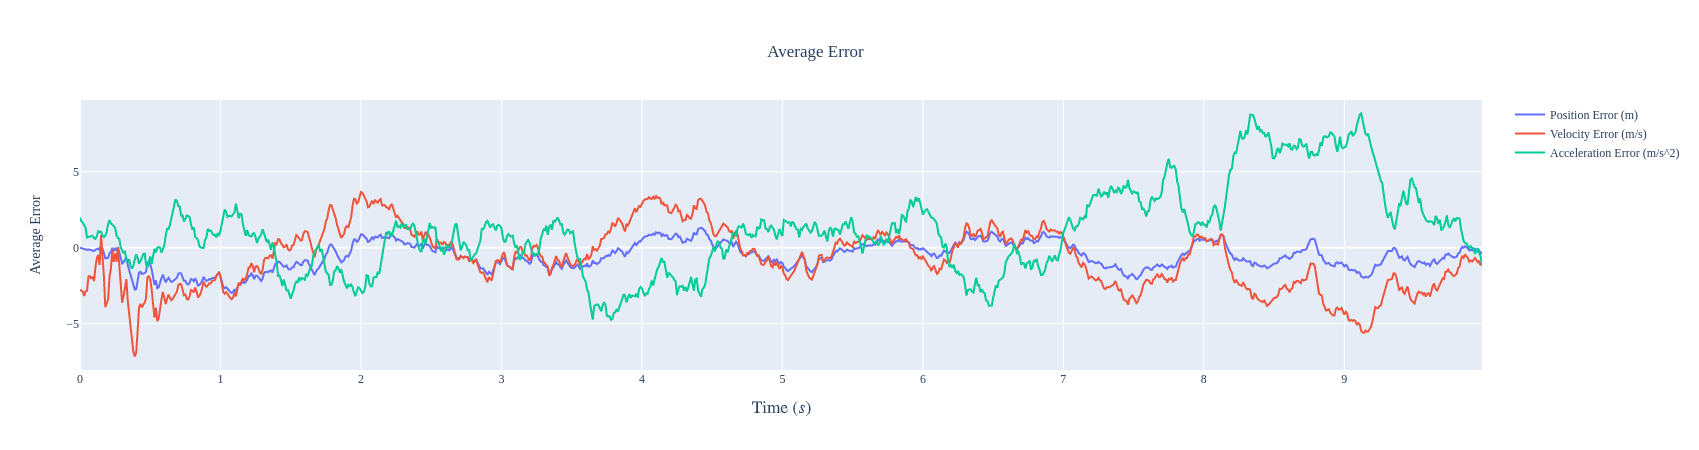

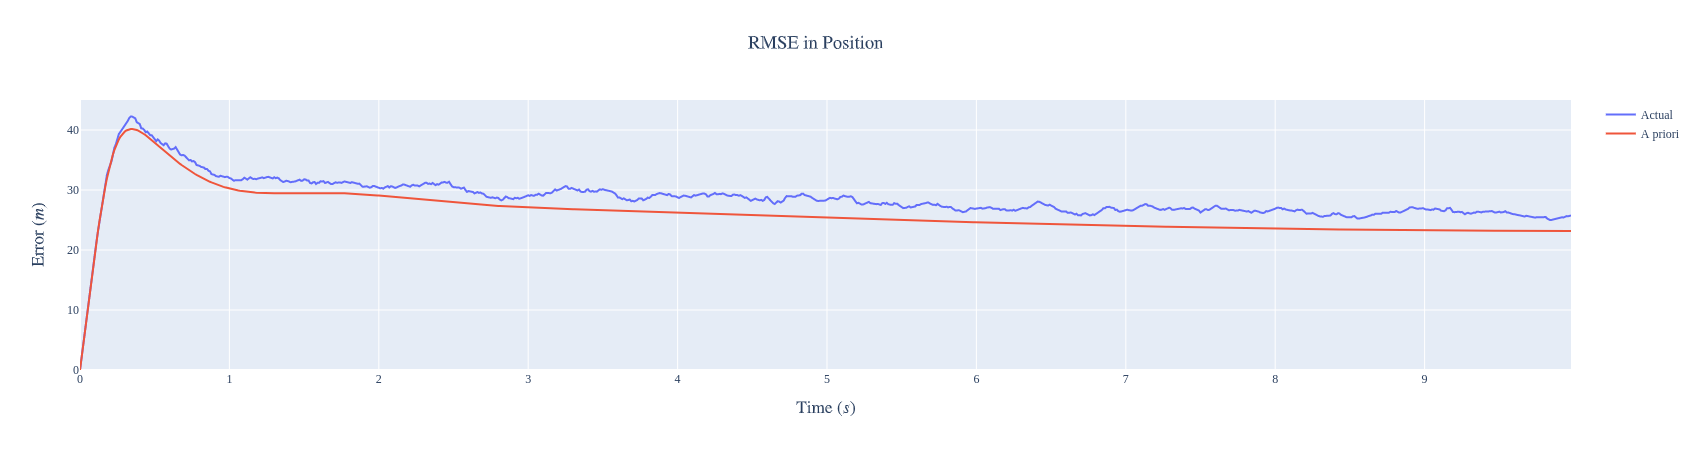

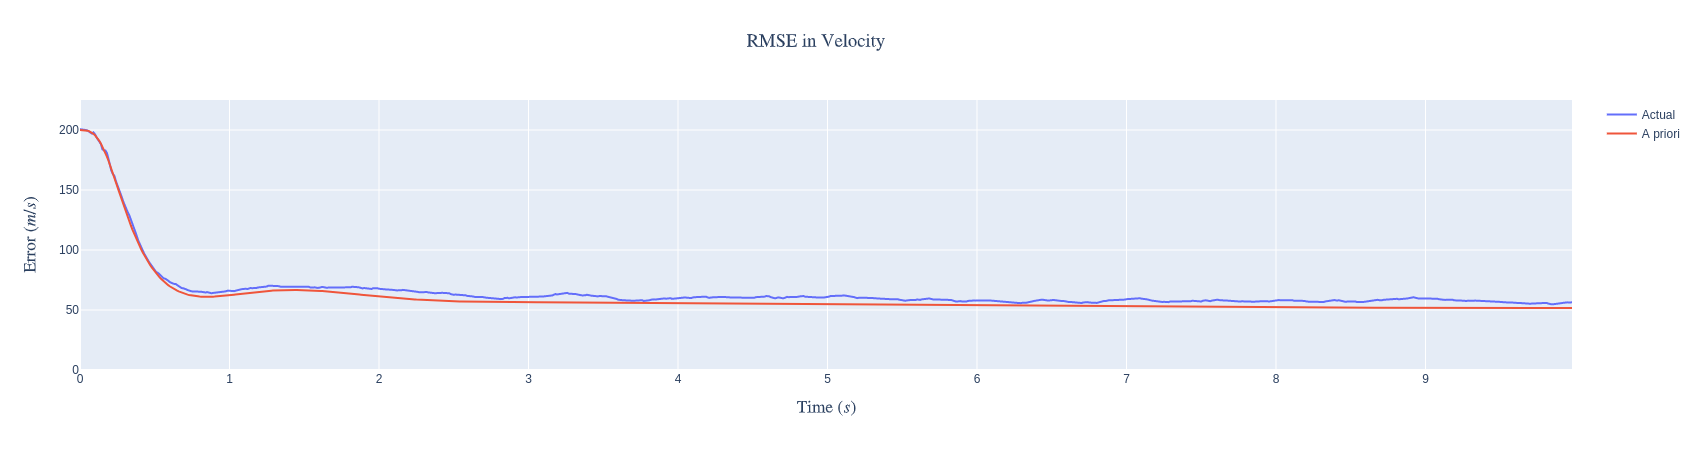

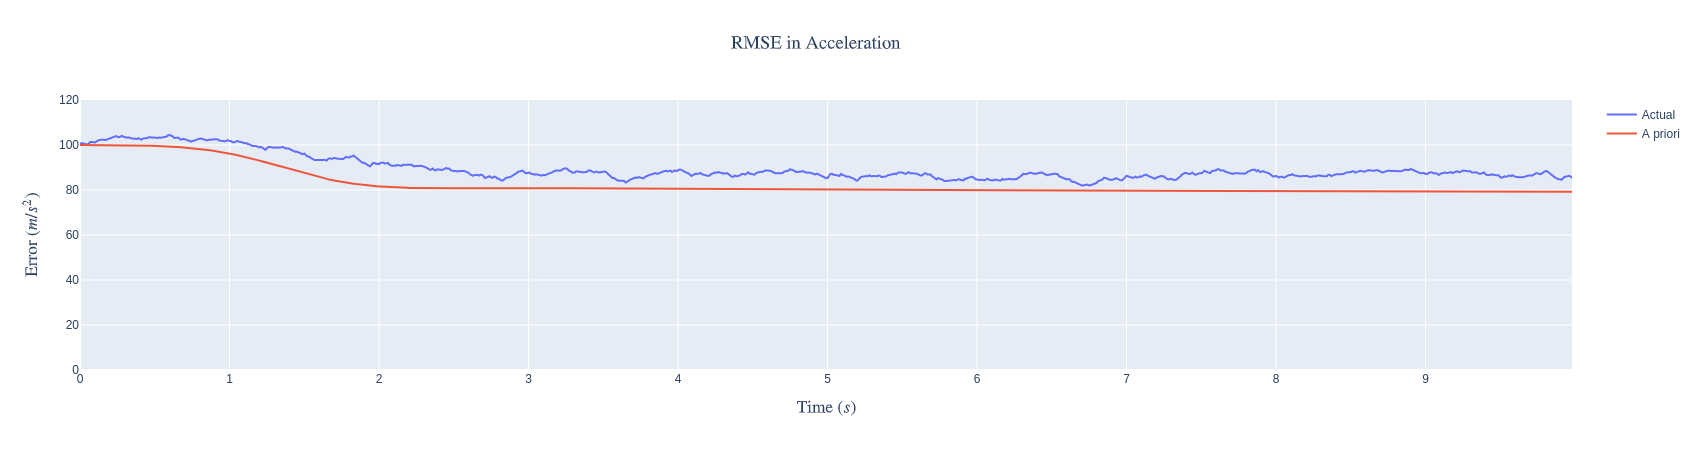

In [300]:
endindex = 999
myfont = "Times New Roman"

# Average error
fig_avg_error = go.Figure()
fig_avg_error.add_trace(go.Scatter(x=timevec[0:endindex], y=avg_error[0,:], name="Position Error (m)"))
fig_avg_error.add_trace(go.Scatter(x=timevec[0:endindex], y=avg_error[1,:], name="Velocity Error (m/s)"))
fig_avg_error.add_trace(go.Scatter(x=timevec[0:endindex], y=avg_error[2,:], name="Acceleration Error (m/s^2)"))
fig_avg_error.update_layout(font = {'family' : myfont}, title={'font': {'family': myfont}, 'text':"Average Error",'xanchor':'center','yanchor':'top','y':0.9,'x':0.48}, xaxis = dict( title = dict (text=r"$\text{Time (} s \text{)}$", font = dict(family = myfont))), yaxis_title="Average Error")
fig_avg_error.show()

# RMSE in position
fig_rmse_pos = go.Figure()
fig_rmse_pos.add_trace(go.Scatter(x=timevec[0:endindex], y=rmse[0,:], name="Actual"))
# fig_rmse_pos.add_trace(go.Scatter(x=timevec[0:endindex], y=np.sqrt(P_actual[0,0,:]), name="Actual"))
fig_rmse_pos.add_trace(go.Scatter(x=filtersol.t[0:endindex], y=std_pos[0:endindex], name='A priori'))
fig_rmse_pos.update_layout(font = {'family' : myfont}, title={'font': {'family': myfont}, 'text':r"$\text{RMSE in Position}$",'xanchor':'center','yanchor':'top','y':0.9,'x':0.48}, xaxis = dict( title = dict (text=r"$\text{Time (} s \text{)}$", font = dict(family = myfont))), yaxis_title=r"$\text{Error (}m \text{)}$)", yaxis = dict( range = [0, 45] ))
fig_rmse_pos.show()

# RMSE in velocity
fig_rmse_vel = go.Figure()
fig_rmse_vel.add_trace(go.Scatter(x=timevec[0:endindex], y=rmse[1,:], name="Actual"))
fig_rmse_vel.add_trace(go.Scatter(x=filtersol.t[0:endindex], y=std_vel[0:endindex], name='A priori'))
fig_rmse_vel.update_layout(title={'text':r"$\text{RMSE in Velocity}$",'xanchor':'center','yanchor':'top','y':0.9,'x':0.48}, xaxis_title=r"$\text{Time (} s \text{)}$", yaxis_title=r"$\text{Error (}m/s \text{)}$)", yaxis = dict(range=[0,225]))
fig_rmse_vel.show()

# RMSE in acceleration
fig_rmse_accel = go.Figure()
fig_rmse_accel.add_trace(go.Scatter(x=timevec[0:endindex], y=rmse[2,:], name="Actual"))
fig_rmse_accel.add_trace(go.Scatter(x=filtersol.t[0:endindex], y=std_accel[0:endindex], name='A priori'))
fig_rmse_accel.update_layout(title={'text':r"$\text{RMSE in Acceleration}$",'xanchor':'center','yanchor':'top','y':0.9,'x':0.48}, xaxis_title=r"$\text{Time (} s \text{)}$", yaxis_title=r"$\text{Error (}m/s^2 \text{)}$)", yaxis = dict(range=[0,120]))
fig_rmse_accel.show()
